Load in the weather, smartmeter and gasmeter data as 3 seperate dataframes. 
Goal is to combine them into one dataframe.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

def load_data():
    global smart
    global gas
    global weather
    df =pd.read_csv("/datc/opschaler/smartmeter_data/P01S01W0373.csv",header=0,delimiter=";",parse_dates=['Timestamp', 'gasTimestamp'])

    # Split the smartmeter and gasmeter data
    smart = df.iloc[:,:7]
    gas = df.iloc[:, 7:]
    
    #Read in weather data
    weather_path = "//datc//opschaler//weather_data//20170101to20180101.txt"
    weather_column_names = ['STN','YYYYMMDD','HH','DD','FH','FF','FX','T','T10','TD','SQ','Q','DR','RH','P','VV','N','U','WW','IX','M','R','S','O','Y']

    weather = pd.read_csv(weather_path, delimiter=',', comment='#', names=weather_column_names, parse_dates=['YYYYMMDD', 'HH'])
    weather['T'] = weather['T']*0.1 # Convert temperature to celcius instead of 0.1 celcius
    weather['HH'] = weather['HH']+':00:00'
    weather['HH'] = weather['HH'].str.strip() # removes the blank spaces infront of the strings
    weather['HH'] = weather['HH'].str.replace('24:00:00', '23:59:59') # KNMI uses 24 for 00 hours.... to have to convert this for to_datetime to be able to work
    weather.loc[:,'datetime'] = pd.to_datetime(weather['YYYYMMDD'].astype(str)+' '+weather['HH'].astype(str)) #create datetime column

In [2]:
"""
Problem: How to merge 3 frames with 3 different datetime's?
The format is the same, but they don't have ''exact'' matches with each other. 
i.e. 

"""
load_data()
# Change all datetime columns to the same column name
smart = smart.rename(index=str, columns={"Timestamp":"datetime"})
gas = gas.rename(index=str, columns={"gasTimestamp":"datetime"})


#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter', 'T', 'Q']]
#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter']]
smart.head()

del weather['STN'], weather['HH'], weather['YYYYMMDD']

# Set datetime as index
weather = weather.set_index(['datetime'])
smart = smart.set_index(['datetime'])
gas = gas.set_index(['datetime'])

In [3]:
"""
Resample the dataframes to 10s intervals.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

"""
weather = weather.resample('10s').pad()
smart = smart.resample('10s').mean()

# gas contains duplicates, they need to be removed
#gas = gas.drop_duplicates()
gas = gas.resample('H').mean() # Does not look nice, but it works

# Create a ''gasPower'' column. This equals the gas used in that hour
gas['gasPower'] = gas['gasMeter'].diff()
# First entry is NaN, replace NaN by second entry
gas['gasPower'][0] = gas['gasPower'][1]
gas = gas.resample('10s').pad()

In [4]:
df = pd.merge(smart, weather,left_index=True, right_index=True)
df = pd.merge(df, gas,left_index=True, right_index=True)
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,DD,FH,FF,FX,...,U,WW,IX,M,R,S,O,Y,gasMeter,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 18:14:20,3717.472,0.0,3883.382,0.0,376.0,0.0,260,30,30,60,...,82,,5,0,0,0,0,0,1599.792,0.194
2017-03-07 18:14:30,3717.473,0.0,3883.382,0.0,381.0,0.0,260,30,30,60,...,82,,5,0,0,0,0,0,1599.792,0.194
2017-03-07 18:14:40,3717.474,0.0,3883.382,0.0,378.0,0.0,260,30,30,60,...,82,,5,0,0,0,0,0,1599.792,0.194
2017-03-07 18:14:50,3717.475,0.0,3883.382,0.0,376.0,0.0,260,30,30,60,...,82,,5,0,0,0,0,0,1599.792,0.194
2017-03-07 18:15:00,3717.476,0.0,3883.382,0.0,380.0,0.0,260,30,30,60,...,82,,5,0,0,0,0,0,1599.792,0.194


<IPython.core.display.Javascript object>


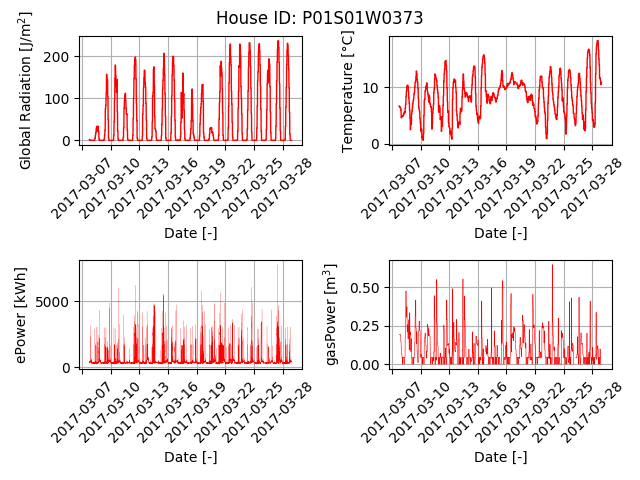

In [7]:
plt.suptitle('House ID: P01S01W0373')

plt.subplot(2,2,1)
plt.plot(df.index, df['Q'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(df.index, df['T'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(df.index, df['ePower'], '-', color='r', linewidth=0.1)
plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,4)
plt.plot(df.index, df['gasPower'], '-', color='r', linewidth=0.4)
plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


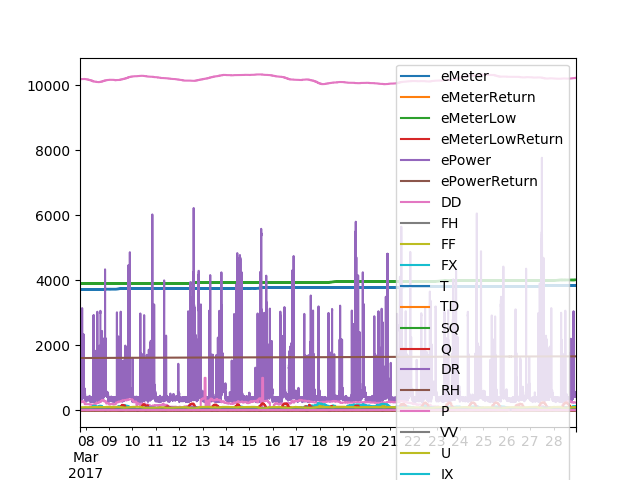

In [17]:
df.plot()

In [18]:
df.shape

(183155, 30)

In [19]:
#df.to_csv('//datc//opschaler//output//combined_weather_gas_smartmeter.csv', sep='\t', index=False)

<IPython.core.display.Javascript object>


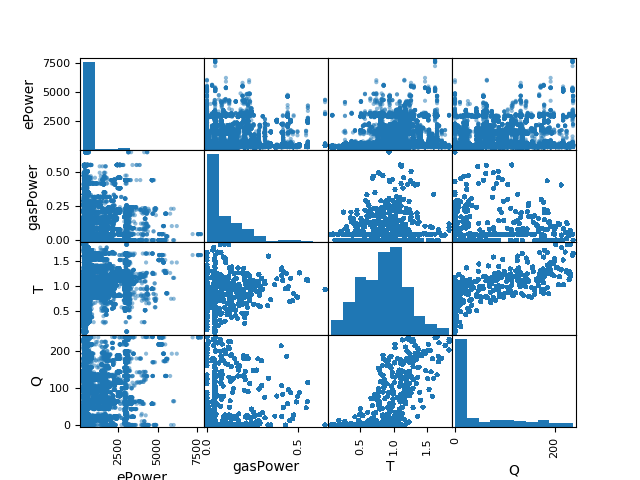

In [20]:
"""
Only keep relevant information for scrumwise sprint 2.
-> smartmeter energy usage data
-> gasmeter gas usage data
-> outside temperature
-> global radiation
"""

df = df[['ePower','gasPower','T','Q']]
_ = pd.plotting.scatter_matrix(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183155 entries, 2017-03-07 18:14:20 to 2017-03-28 23:00:00
Freq: 10S
Data columns (total 30 columns):
eMeter             180212 non-null float64
eMeterReturn       180212 non-null float64
eMeterLow          180212 non-null float64
eMeterLowReturn    180212 non-null float64
ePower             180212 non-null float64
ePowerReturn       180212 non-null float64
DD                 183155 non-null int64
FH                 183155 non-null int64
FF                 183155 non-null int64
FX                 183155 non-null int64
T                  183155 non-null float64
T10                183155 non-null object
TD                 183155 non-null int64
SQ                 183155 non-null int64
Q                  183155 non-null int64
DR                 183155 non-null int64
RH                 183155 non-null int64
P                  183155 non-null int64
VV                 183155 non-null int64
N                  183155 non-null object
U        